# Model crazy beliefs with Gaussian mixture models

Useful documents:

https://cran.r-project.org/web/packages/bgmm/bgmm.pdf

http://bgmm.molgen.mpg.de/

https://www.jstatsoft.org/article/view/v047i03/v47i03.pdf

## Load packages

In [312]:
library(bgmm)

This package offers the following model-fitting functions:

supervised -- for supervised learning, where all examples have a label guaranteed to be true
unsupervised -- for unsupervised learning, where there are no labels for any examples
semisupervised --  for semi-supervised learning, where examples either have (a) a certain label or (b) no label at all. There are no uncertain labels
soft -- for "soft" semi-supervised learning: for examples that have labels, these are specified as probabilities over all possible labels.
belief -- for "belief-based" partially supervised learning: for examples that have labels, these are specified as probabilities over all possible labels.

*NB the difference between soft and belief-based learning are not clear to me yet.*

**General arguments for all methods:**

*knowns:* a matrix of coordinates for each labeled item (ie, how "spiky" or "smooth" each labeled fruit example is). Each row is one item, each column is one feature dimension. For our study there is only one feature dimension (spiky/smooth) so examples are specified as a column vector, with one element for each labeled item in the experiment.

*x:* a matrix indicating the coordinates for all *unlabeled* items. In our studies, the unlabeled items are just the items used for grid test 1 and grid test 2.

*class:* for supervised and semisupervised learning, this is a vector indicating the true class label for each item denoted in "knowns"

*P or B:* For partially supervised learning (soft or belief), this is a matrix indicating, for each item listed in "knowns", the probability that the item has each possible label. P / B are specified as a matrix with each row corresponding to one item (as denoted in "knowns") and each column corresponding to one possible label. In our study there are two possible labels ("Raw","Cooked"), so this would be a matrix with two columns. For a given row, the first column indicates the probability that the item has label 1 ("Raw") and the second indicates the probability that the item has lable 2 ("Cooked").

## Some example uses of the package for supervised and semi-supervised learning

**Example: Fitting a supervised model.**

The models are fit by calling the function with the required parameters specified and storing the result. Here is an example for a fully supervised model, which only needs (1) the coordinates of the stimuli and (2) the true class labels for each.

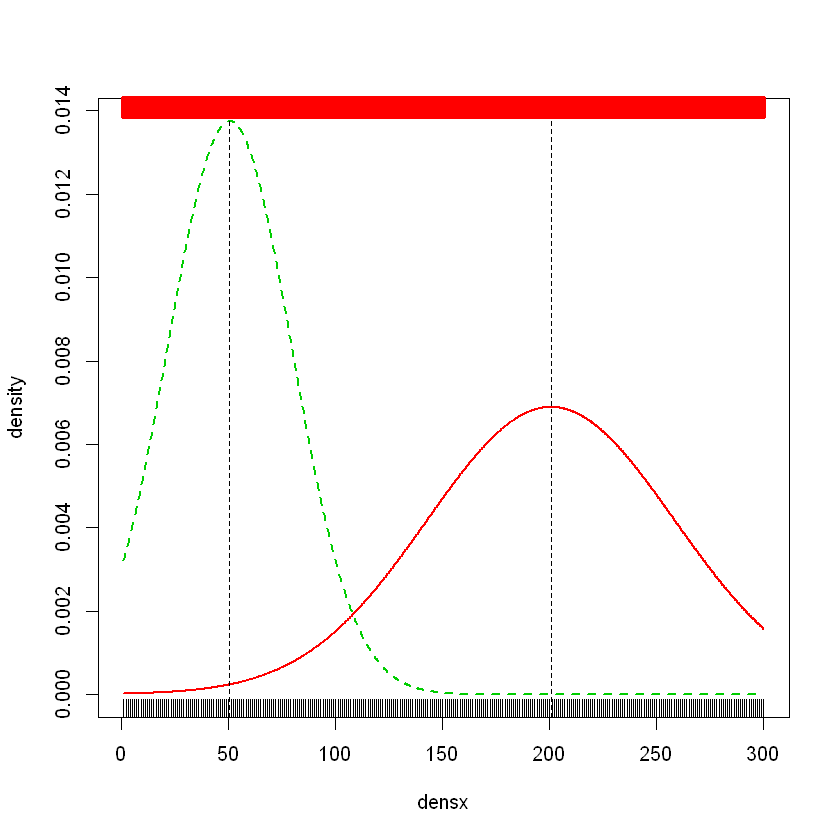

In [313]:
k <- c(1:300) #x values for training data
cl <- c(rep(1, times = 100), rep(0, times = 200)) #Vector of labels for supervised items
sup.mod <- supervised(knowns = k, class=cl) #Fit supervised mixture model
plot(sup.mod) #Plot fitted model

**Example: Fitting a semi-supervised model where the true class label is known for only a few items**

Example assumes items 51-60 get label 1 and items 251-260 get label 2




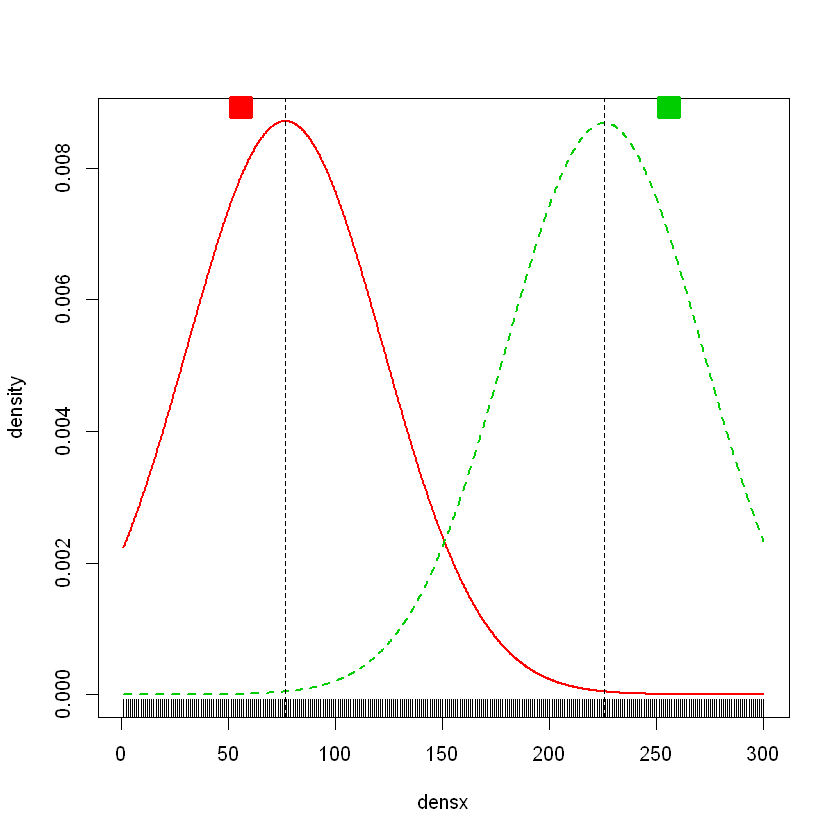

In [314]:
k <- c(51:60, 251:260) #vector indicating labeled example x values.
cl <- c(rep(1, times = 10), rep(2, times = 10))  #True class labels for the items denoted in k
uk <- c(1:300) #Unlabeled items

semi.mod <- semisupervised(knowns = k, X = uk, class =cl)   #Fit model
plot(semi.mod)

You can look at all model parameters using the *summary(semi.mod)* command, which returns the following information, each a different field in the model object:

- pi: Probability of sampling from each of the 2 components
- mu: Estimated mean of each component
- cvar: Estimated variance and covariances of the components
- P: The P matrix for the labeled items (estimated from the "class" argument above)
- m: The number of labeled items
- n: Total number of items seen during learning (labeled and unlabeled)
- k: Total number of possible classes / components in mixture
- d: Not sure!
- likelihood: Log likelihood of the data given the model
- n.steps: Number of steps in the EM-algorithm (I think)
- tij: Matrix providing, for each item in the training set (rows) and each label - (cols), the probability that the item gets that label
- X: Coordinates of unlabeled items
- knowns: Coordinates of labeled items
- model.structure: Not sure!
- dof: Degrees of freedom for fitting the model
- class: Labels provided for the labeled items

In [315]:
summary(semi.mod)

                  Length Class  Mode   
pi                  2    -none- numeric
mu                  2    -none- numeric
cvar                2    -none- numeric
P                  40    -none- numeric
m                   1    -none- numeric
n                   1    -none- numeric
k                   1    -none- numeric
d                   1    -none- numeric
likelihood          1    -none- numeric
n.steps             1    -none- numeric
tij               640    -none- numeric
X                 300    -none- numeric
knowns             20    -none- numeric
model.structure     4    -none- list   
dof                 1    -none- numeric
pca.dim.reduction   1    -none- numeric
class              20    -none- numeric

The model can be used to predict the label probabilities for new observations using the predict function:

In [316]:
newx <- c(0:299) + .5 #Some new values for X
p <- predict(semi.mod, newx) #Predict labels for newx using semi.mod
summary(p)

             Length Class  Mode   
tij.X        600    -none- numeric
tij.knowns     0    -none- NULL   
class.X      300    -none- numeric
class.knowns   0    -none- NULL   

Predict returns the following fields:

- tij.X: For each item predicted (rows), probability of each label (cols)
- tij.knowns: Empty strings (no knowns provided for predicting!)
- class.X: The most likely category label for each predicted item
- class.knowns: Empty strings (no knowns when predicting!)

The most interesting output is tij, the predicted probability of each label for the new observations, which can be plotted as follows:

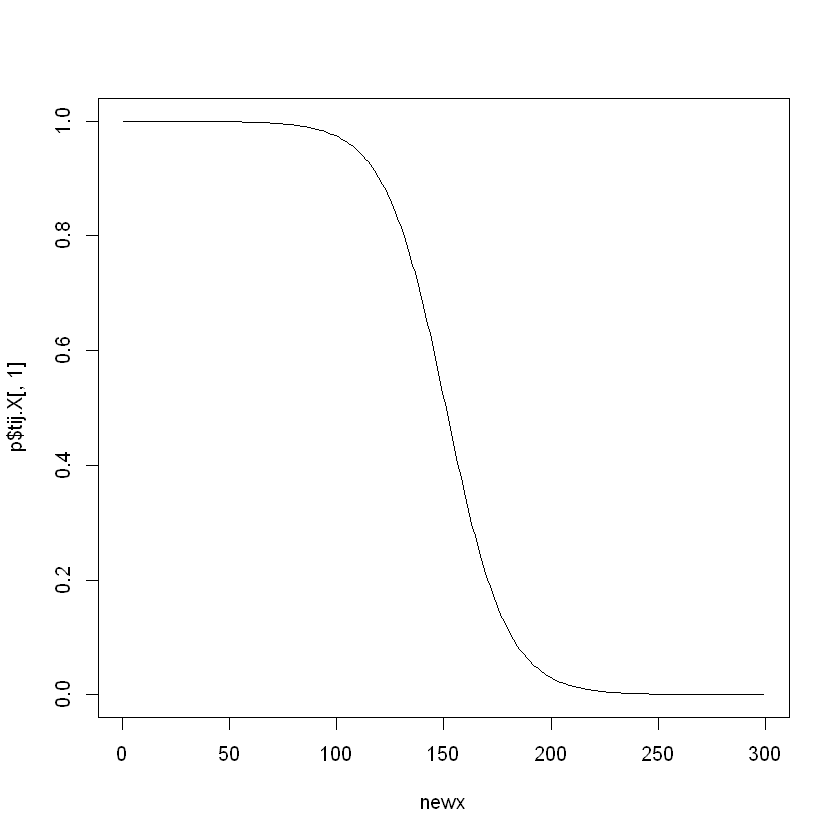

In [317]:
plot(newx, p$tij.X[,1], type = "l")  #plots probability of getting label 1 for each value of spikiness listed in xnew

# Simulating the experiments

### Functions

Function to get weight for farther source.

In [318]:
get.pwt <- function(s, f, c){
    #Return proportion of weight given to far source, given
    #c = distance between initial boundary and close source
    #f = distance between initial boundary and far source
    #s = amount of shift
    
    (s-c)/(f-c)
}

In [319]:
#Function to fit weighted Gaussian mixture models with online learning
plt.wgmm.seq <- dget("plot_wgmm_seq.R")

## Equal weight to both sources

### Experiment 1

In our study there are 20 labelled trials (2 items each repeated 10 times in random order, labeled by the "Captain"), followed by 40 unlabeled trials (grid test 1), followed by 301 trials labeled by the two sources, followed by 40 unlabeled items in grid test 2. We want to model learning using partially-supervised algorithms (soft or belief), which allow us to indicate the uncertainty that comes with two sources who disagree. To do this we need to indicate the set of stimulus items that appear with labels, the set of items that appear without labels, and the degree of label certainty associated with each labeled item.

**NOTE**: In standard use the algorithm doesn't care about the order in which items are encountered--a single model is fit to all data. (For online trust updating this will be different.) With this in mind, the unlabeled items are those appearing in grid test 1 and grid test 2, which range from 60 to 240 in steps of 10, with each appearing twice in each of the 2 grid tests. So unlabelled items can be encoded in the following vector:

In [320]:
tmp <- c(6:24)*10 #temporary vector counting from 60 to 240 in steps of 10
uk <- c(tmp, tmp, tmp, tmp)  #vector of "unknowns" that includes 4 repetitions of the grid

The labeled items include (1) 10 repetitions each of the 2 captain-labeled items, and (2) items 0-300 each appearing once and labeled by the 2 sources. So we create a vector to hold the spikiness values for these items as follows:

In [321]:
k <- c(rep(100, times = 10), rep(200, times = 10), 0:300) 

We then need a third data structure to store the labels provided for each of these items. Since this is partially-supervised learning, we want a matrix with 321 rows (one for each element of k) and 2 columns (one for each possible label, raw or cooked). The numbers in this matrix will indicate, for each item in k, the probability that it should be "raw" (column 1) or "cooked" (column 2) based on the labels provided by the sources. For the first 20 items, these probabilities will be certain (0 or 1) since the Captain is providing them. Let's make a vector for the captain's labels, assuming the lower numbers get the label 1 and the higher numbers get the label 0:

In [322]:
clab <- c(rep(1, times = 10), rep(0, times = 10)) #Captain gives first 10 items in k label 1 and second 10 items label 0.

This simulation assumes the two sources always get equal weighting--thus for the remaining 301 items, the probabilities will be the mean of the labels provided by the 2 sources: certain where the 2 sources agree, and 0.5 for items where they disagree. One easy way to make these "soft" probabilities is to begin with the labels that are provided by each source, coding one label with 1 and the other with 0. Source 1 has a boundary at 50 while source 2 has a boundary at 165 so the relevant labels and associated probability can be computed as follows:

In [323]:
s1 <- c(rep(1, times = 51), rep(0, times = 250))  #Source 1 labels
s2 <- c(rep(1, times = 166), rep(0, times = 135))  #Source 2 labels        

For these 301 items, the probability that each gets label 1 is just the mean of these two vectors. For values from 0-50, both sources have a 1 so the mean will be 1 for each. For values from 51-176, s1 has a 0 and s2 has a 1 so the mean will b 0.5. For the remaining items, both sources have a 0, so the mean will be 0 for each. So we can specify the probability of getting label 1 for the 20 items labeled by the captain and the 301 items labeled by the 2 sources as follows:

In [324]:
plab1 <- c(clab, (s1 + s2)/2)  #captain's labels followed by mean of s1 and s2 labels

Since this is binary classification, the probability of the other label is just $1 - plab1$. We can compute this, then bind the two vectors together to provide a matrix of "soft" labels:

In [325]:
plab2 <- 1 - plab1
b <- cbind(plab1, plab2)   #bind the two vectors describing label probabilities into a single 2-column matrix.

Now we have all the elements we need to fit and investigate the model. First we want to see what the model looks like after learning from *just* the captain and the initial grid, before exposure to the 2 companions. At this point there are 20 "known" items (the ones labeled by the captain) and 40 "unknowns" (the one encountered during the grid test). Then we want to see what the model looks like after being fitted to all data. We can fit the two models and plot them as follows:


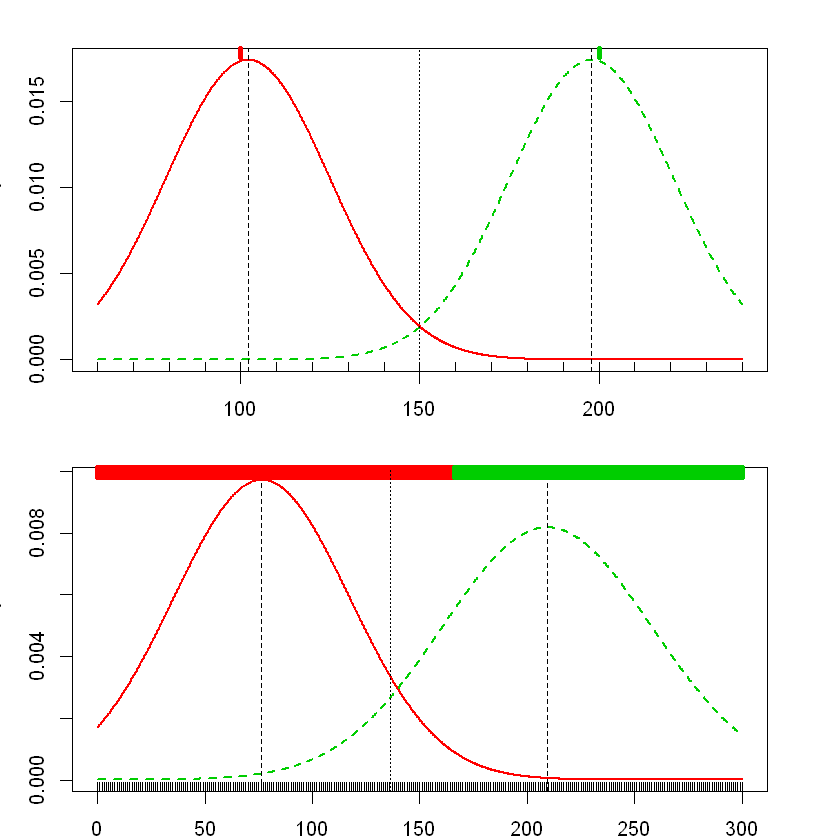

In [326]:
mod1 <- soft(knowns = k[1:20], X = uk[1:38], P = b[1:20,]) #First 20 knowns and first 38 unknowns, on the grid
mod2 <- soft(knowns = k, X = uk, P = b) #All knowns, unknowns, and soft labels

xnew <- c(0:3000)/10
m1pred <- predict(mod1, xnew)
m2pred <- predict(mod2, xnew)

pdiff1 <- abs(m1pred$tij.X[,1] - m1pred$tij.X[,2])
b1 <- xnew[pdiff1==min(pdiff1)]

pdiff2 <- abs(m2pred$tij.X[,1] - m2pred$tij.X[,2])
b2 <- xnew[pdiff2==min(pdiff2)]

par(mfrow = c(2,1), mar = c(2,3,2,3)) #Plot a 2-row panel figure with margins set according to mar
plot(mod1); abline(v = b1, lty = 3)     #Plot model 1 in the first panel and add a vertical dotted line at X = 150
plot(mod2); abline(v = b2, lty = 3)     #Plot model 2 in the second panel and add a vertical dotted line at X = 150

In [327]:
pdf("exp1_gmm_fw.pdf", width=8, height=8)
par(mfrow = c(2,1), mar = c(2,3,2,3)) #Plot a 2-row panel figure with margins set according to mar
plot(mod1); abline(v = b1, lty = 3)     #Plot model 1 in the first panel and add a vertical dotted line at X = 150
plot(mod2); abline(v = b2, lty = 3)     #Plot model 2 in the second panel and add a vertical dotted line at X = 150
dev.off()

png 
  2

The boundary begins at 150 (top) and shifts slightly toward the far source (left). How can we figure out where the boundary is? One way is to use the fitted model to predict probabilities for the two labels and find the value of X for which the two probabilities are equal:

In [328]:
c(b1, b2, b2-b1)


[1] 150.0 136.5 -13.5

So boundary shifts toward the far source, comparable to the experiment.

## Remaining studies

Read in data structures to simulate experiments (copied from discriminative model notebook)

In [329]:
#All studies
x <- 0:300 #Set of stimulus items
gtest <- c(6:24)*10 #grid test items

#Experiment 1
citems <- c(rep(100, times = 10), rep(200, times = 10)) #Captain-labelled items
citems <- citems + ((runif(20)*2) - 1)  #Add small amount of noise to captain-labeled items
clabs <- c(rep(1, times = 10), rep(0, times = 10))      #Category labels for captain-labelled items

is <- rep(0, times = 301) #initialize source with zeros
e1s1 <- is; e1s2 <- is    #initalize experiment 1 sources
e1s1[1:51] <- 1           #Source 1 labels items 0-50 with 1 
e1s2[1:166] <- 1          #Source 2 labels itesm 0-165 with 1

#Experiment 2
e2s1 <- e1s2              #Source 1 (fixed) is the same as source 2 in experiment 1

e2s2 <- matrix(0, 15, 301)  #Source 2 boundary varies across learners in this experiment;
                            #We will simulate 15 different far sources
for(i1 in c(1:15)) e2s2[i1, c(1:(i1*10))] <- 1 #Source 2 labels for 15 source

#Experiment 3
e3citems <- c(rep(30, times = 10), rep(170, times = 10))    #For experiment 3, captain-labeled items are at 30 and 170
e3citems <- e3citems + ((runif(20)*2) - 1)  #Add small amount of noise to captain-labeled items
e3s1 <- is; e3s2 <- is    #initalize experiment 3 sources
e3s1[1:101] <- 1           #Source 1 labels items 0-100 with 1 
e3s2[1:201] <- 1          #Source 2 labels itesm 0-200 with 1

#Experiment 4
e4citems <- c(30, 170)    #For experiment 4, captain-labeled items are at 30 and 170

#Source labels for experiment 4
e4has1 <- is; e4has1[1:126] <- 1               #High agreement
e4has2 <- is; e4has2[1:176] <- 1               
e4mas1 <- is; e4mas1[1:101] <- 1               #moderate agreement
e4mas2 <- is; e4mas2[1:201] <- 1               
e4mds1 <- is; e4mds1[1:76] <- 1               #moderate disagreement
e4mds2 <- is; e4mds2[1:226] <- 1               
e4hds1 <- is; e4hds1[1:51] <- 1               #high disagreement
e4hds2 <- is; e4hds2[1:251] <- 1               



### Experiment 2

In study 2 the initial learning (model 1) is the same a Experiment 1, so we will re-use here. Each participant sees different feedback information during the multiple-supervision phase, so we will fit a separate model-2 for each simulated participant. Rather than randomly sampling these we will just compute model predictions for an equally-spaced range of values.

In [330]:
nsjs <- dim(e2s2)[1] #Number of simulated subjects

xnew <- c(0:3000)/10 #Grid points to find boundary

b2 <- rep(NA, times = nsjs) #Initialize vector for boundary-2

for(i1 in c(1:nsjs)){
    #For each subject
    plab1 <- c(clab, (e2s1 + e2s2[i1,])/2)  #captain's labels followed by mean of s1 and s2 labels
    plab2 <- 1 - plab1
    b <- cbind(plab1, plab2) #Soft labels
    
    #Fit model 2
    mod2 <- soft(knowns = k, X = uk, P = b)

    p <- predict(mod2, xnew)
    pdiff <- abs(p$tij.X[,1] - p$tij.X[,2])
    b2[i1] <- xnew[pdiff==min(pdiff)]
    }


bshift <- b2 - b1
bshift

[1] -14.4 -14.3 -13.9 -13.8 -13.6 -13.3 -12.5 -12.0 -10.8  -9.3  -7.3  -4.7
[13]  -1.6   1.8   6.3

In [331]:
t.test(bshift)


	One Sample t-test

data:  bshift
t = -5.2824, df = 14, p-value = 0.0001158
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -12.504243  -5.282424
sample estimates:
mean of x 
-8.893333 


Boundary shifts significantly toward far source.

In [332]:
pwt <- rep(0, times = nsjs)
s <- b2 - b1   #Amount of shift
f <- rowSums(e2s2) - b1  #Distance of variable source to initial boundary
c <- sum(e2s1) - b1      #Distance of fixed source to initial boundary

for(i1 in c(1:15)) pwt[i1] <- get.pwt(s[i1], f[i1], c)

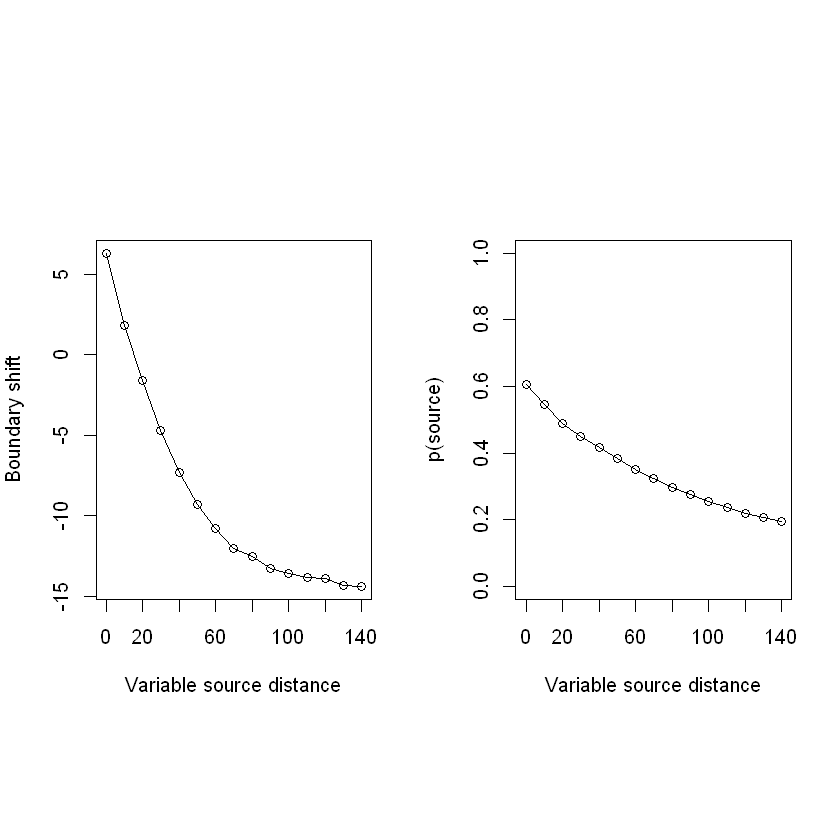

In [333]:
par(mfrow = c(1,2), mar = c(10,4,10,2))
plot(150 - rowSums(e2s2), b2- b1, type = "o", ylab = "Boundary shift", xlab = "Variable source distance")
plot(150 - rowSums(e2s2), pwt, type = "o", ylab = "p(source)", xlab = "Variable source distance",
    ylim = c(0,1))

In [334]:
postscript("e2_gmm_fixwt.ps", width=8, height=8)
par(mar = c(4,3,2,2))
plot(150 - rowSums(e2s2), pwt, type = "o", ylab = "p(source)", xlab = "Variable source distance",
    ylim = c(0,1), pch=16)
dev.off()

png 
  2

Boundary shift declines nonlinearly with distance of far source, as does estimate of weight given to far source, but still not with nonlinear characteristic of data.

### Experiment 3

In experiment 3, the Captain provided labels at 70, 130, promoting an initial boundary near 100. Source 1 then used a boundary at 100, and source 2 a boundary at 200. We can simualte this study using the same code as experiment 1, but changing the fully-supervised (Captain's) labels, and using the experiment 3 labels for S1 and S2.

In [335]:
k[1:20] <- e3citems #Replace items labelled by captain
plab1 <- c(clab, (e3s1 + e3s2)/2) #Probability of label 1
plab2 <- 1 - plab1                #Probability of label 2
b <- cbind(plab1, plab2)          #Label probability matrix
mod1 <- soft(knowns=k[1:20], X=uk[1:38], P=b[1:20,]) #Fit initial model
mod2 <- soft(knowns = k, X = uk, P = b) #Fit model 2 

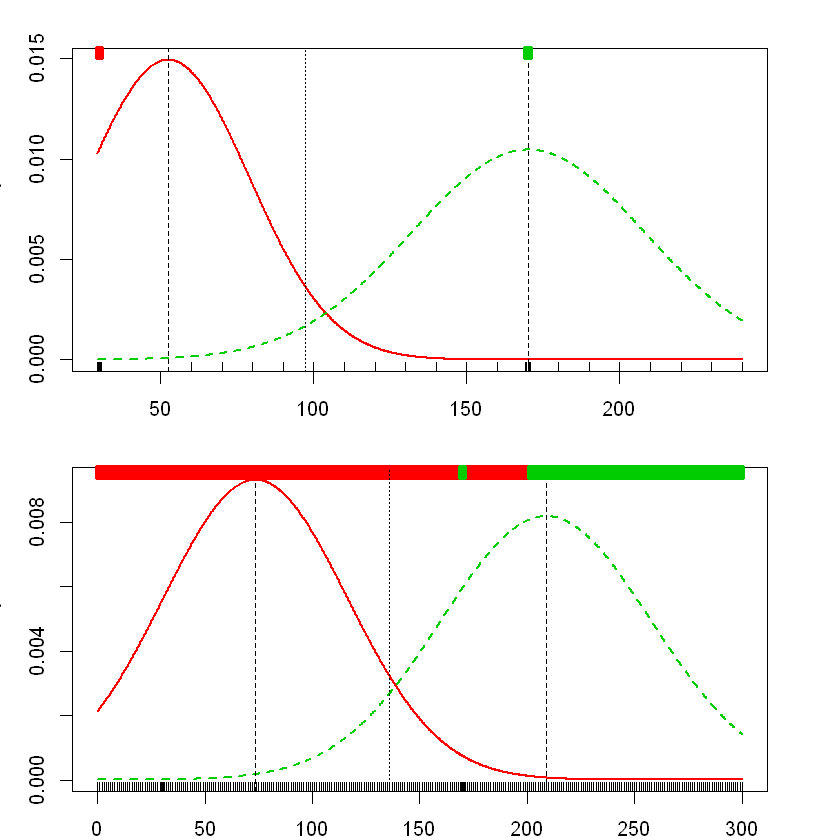

In [336]:
xnew <- c(0:3000)/10
m1pred <- predict(mod1, xnew)
m2pred <- predict(mod2, xnew)

pdiff1 <- abs(m1pred$tij.X[,1] - m1pred$tij.X[,2])
b1 <- xnew[pdiff1==min(pdiff1)]

pdiff2 <- abs(m2pred$tij.X[,1] - m2pred$tij.X[,2])
b2 <- xnew[pdiff2==min(pdiff2)]

par(mfrow = c(2,1), mar = c(2,3,2,3)) #Plot a 2-row panel figure with margins set according to mar
plot(mod1); abline(v = b1, lty = 3)     #Plot model 1 in the first panel and add a vertical dotted line at X = 150
plot(mod2); abline(v = b2, lty = 3)     #Plot model 2 in the second panel and add a vertical dotted line at X = 150

In [337]:
postscript("e3_gmm_fixwt.ps", width=8, height=8)
par(mfrow = c(2,1), mar = c(2,3,2,3)) #Plot a 2-row panel figure with margins set according to mar
plot(mod1); abline(v = b1, lty = 3)     #Plot model 1 in the first panel and add a vertical dotted line at X = 150
plot(mod2); abline(v = b2, lty = 3)     #Plot model 2 in the second panel and add a vertical dotted line at X = 150
dev.off()

png 
  2

In [338]:
xnew <- c(0:3000)/10
m1pred <- predict(mod1, xnew)
m2pred <- predict(mod2, xnew)

pdiff1 <- abs(m1pred$tij.X[,1] - m1pred$tij.X[,2])
b1 <- xnew[pdiff1==min(pdiff1)]

pdiff2 <- abs(m2pred$tij.X[,1] - m2pred$tij.X[,2])
b2 <- xnew[pdiff2==min(pdiff2)]

c(b1, b2, b2-b1)

[1]  97.3 135.8  38.5

Predicts large shift toward midline

In [339]:
get.pwt(b2-b1, b1, abs(100-b1))

[1] 0.3784355

Less weight given to far source

### Experiment 4

In this experiment the Captain provides the same labels as Experiment 3, and the two sources again provide labels based on boundaries equidistant from the range midpoint at 150. Different conditions vary *how far* from the midpoint the two source boundaries are (high agreement, moderate agreement, moderate disagreement, high disagreement). This block will therefore fit four different "after" models and compute the boundary shift for each.

In [340]:
bshift <- rep(NA, times = 4) #Initialize vector to hold boundary shift results
xnew <- c(0:3000)/10 #Grid to find boundary

#High agreement condition
plab1 <- c(clab, (e4has1 + e4has2)/2) #Probability of label 1
plab2 <- 1 - plab1                #Probability of label 2
b <- cbind(plab1, plab2)          #Label probability matrix
modha <- soft(knowns = k, X = uk, P = b) #Fit high agreement model
p <- predict(modha, xnew)
pdiff <- abs(p$tij.X[,1] - p$tij.X[,2])
b2 <- xnew[pdiff==min(pdiff)]
bshift[1] <- b2 - 100

#Moderate agreement condition
plab1 <- c(clab, (e4mas1 + e4mas2)/2) #Probability of label 1
plab2 <- 1 - plab1                #Probability of label 2
b <- cbind(plab1, plab2)          #Label probability matrix
modma <- soft(knowns = k, X = uk, P = b) #Fit moderate agreement model
p <- predict(modma, xnew)
pdiff <- abs(p$tij.X[,1] - p$tij.X[,2])
b2 <- xnew[pdiff==min(pdiff)]
bshift[2] <- b2 - 100

#Moderate disagreement condition
plab1 <- c(clab, (e4mds1 + e4mds2)/2) #Probability of label 1
plab2 <- 1 - plab1                #Probability of label 2
b <- cbind(plab1, plab2)          #Label probability matrix
modmd <- soft(knowns = k, X = uk, P = b) #Fit moderate disagreement model
p <- predict(modmd, xnew)
pdiff <- abs(p$tij.X[,1] - p$tij.X[,2])
b2 <- xnew[pdiff==min(pdiff)]
bshift[3] <- b2 - 100

#High disagreement condition
plab1 <- c(clab, (e4hds1 + e4hds2)/2) #Probability of label 1
plab2 <- 1 - plab1                #Probability of label 2
b <- cbind(plab1, plab2)          #Label probability matrix
modhd <- soft(knowns = k, X = uk, P = b) #Fit high disagreement model
p <- predict(modhd, xnew)
pdiff <- abs(p$tij.X[,1] - p$tij.X[,2])
b2 <- xnew[pdiff==min(pdiff)]
bshift[4] <- b2 - 100



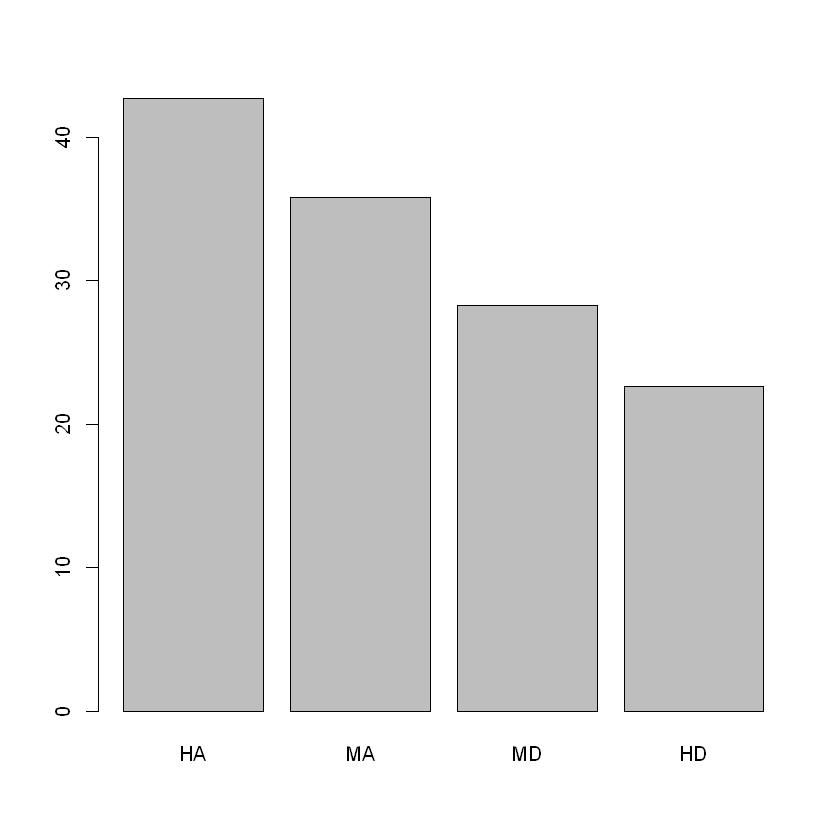

In [341]:
barplot(bshift, names=c("HA","MA","MD", "HD"))

All models shift toward the midpoint, with stronger shift for higher agreement between sources.

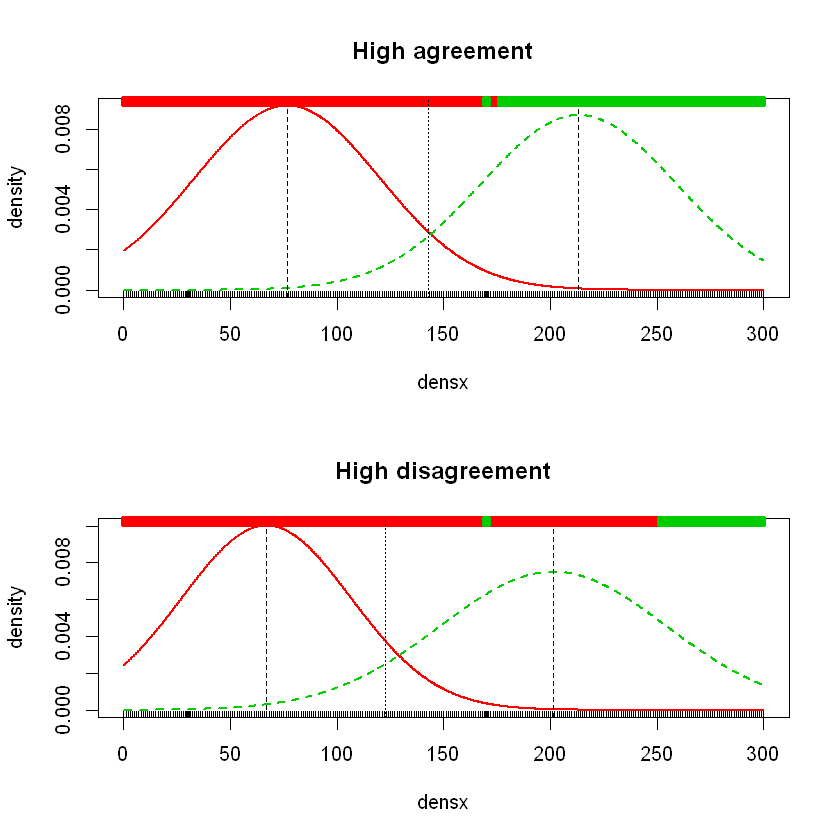

In [342]:
xnew <- c(0:3000)/10
m1pred <- predict(modha, xnew)
m2pred <- predict(modhd, xnew)

pdiff1 <- abs(m1pred$tij.X[,1] - m1pred$tij.X[,2])
b1 <- xnew[pdiff1==min(pdiff1)]

pdiff2 <- abs(m2pred$tij.X[,1] - m2pred$tij.X[,2])
b2 <- xnew[pdiff2==min(pdiff2)]

par(mfrow = c(2,1))
plot(modha); title("High agreement"); abline(v=b1, lty = 3)
plot(modhd); title("High disagreement"); abline(v=b2, lty = 3)

# Oracle-weighted models

In these simulations we use the initial model formed from captain-labeled items and the first grid test to determine soft weights for items labeled from the two sources. When both sources agree, the model is given probabilities of 1 for the corresponding label. When they disagree, however, the weight given to Label A is exactly the probability that the item has label A according to the initial model, and same for B. **Note** that, since the same initial model is used to weight all subsequent observations, the model can be fit as a full batch, rather than getting updated online. Thus the order in which the items are encountered doesn't matter. Batch-trained models are faster to fit, so here is raw code to do this:

In [343]:
k <- c(rep(100, times = 10), rep(200, times = 10), 0:300) 
clab <- c(rep(1, times = 10), rep(0, times = 10)) #Captain gives first 10 items in k label 1 and second 10 items label 0.

s1 <- c(rep(1, times = 51), rep(0, times = 250))  #Source 1 labels
s2 <- c(rep(1, times = 166), rep(0, times = 135))  #Source 2 labels      

#Fit initial model:
mod1 <- soft(knowns = k[1:20], X = uk[1:38], P = b[1:20,]) #First 20 knowns and first 38 unknowns, on the grid

#Probability label=1
agree <- s1==s2 #Logical indicating where sources agree
plab1 <- (s1 + s2)/2 #Initialize with mean of two sources 
owt <- predict(mod1, x)$tij.X[,1] #Oracle-weighted probabilty stimulus is 1
plab1[!agree] <- owt[!agree] #Where they disagree, replace plab1 with oracle-weighted probability
plab1 <- c(clab, plab1)  #append captain's labels followed by mean of s1 and s2 labels

plab2 <- 1 - plab1
b <- cbind(plab1, plab2)
mod2 <- soft(knowns = k, X = uk, P = b) #Fit second model


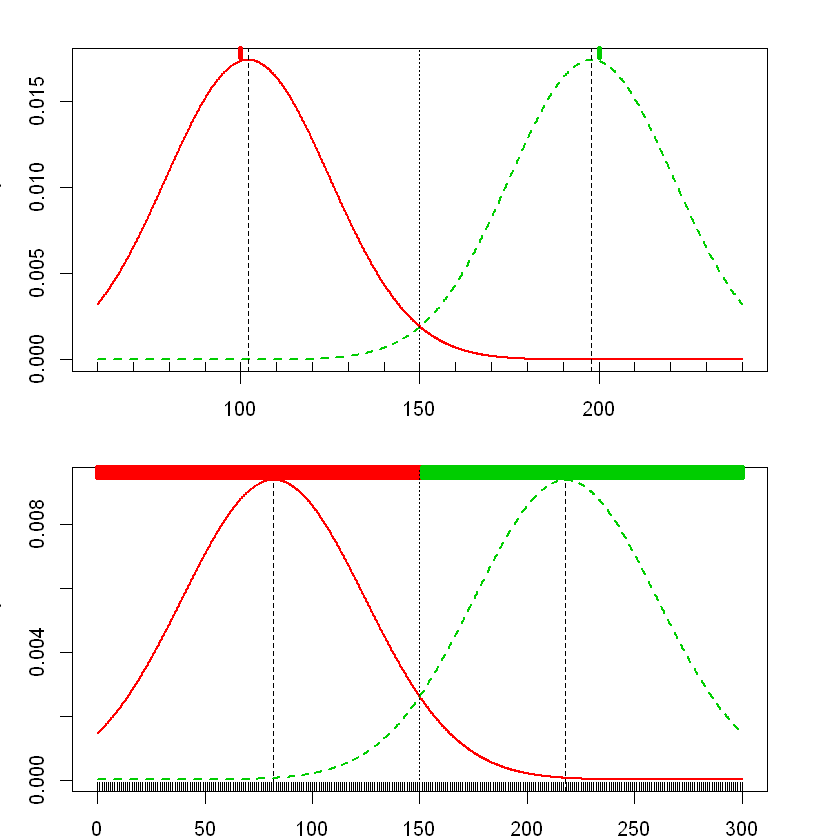

In [344]:
xnew <- c(0:3000)/10
m1pred <- predict(mod1, xnew)
m2pred <- predict(mod2, xnew)

pdiff1 <- abs(m1pred$tij.X[,1] - m1pred$tij.X[,2])
b1 <- xnew[pdiff1==min(pdiff1)]

pdiff2 <- abs(m2pred$tij.X[,1] - m2pred$tij.X[,2])
b2 <- xnew[pdiff2==min(pdiff2)]

par(mfrow = c(2,1), mar = c(2,3,2,3)) #Plot a 2-row panel figure with margins set according to mar
plot(mod1); abline(v = b1, lty = 3)     #Plot model 1 in the first panel and add a vertical dotted line at X = 150
plot(mod2); abline(v = b2, lty = 3)     #Plot model 2 in the second panel and add a vertical dotted line at X = 150

In [262]:
pdf("e2_gmm_owt.pdf", w=8, h=8)
par(mfrow = c(2,1), mar = c(2,3,2,3)) #Plot a 2-row panel figure with margins set according to mar
plot(mod1); abline(v = b1, lty = 3)     #Plot model 1 in the first panel and add a vertical dotted line at X = 150
plot(mod2); abline(v = b2, lty = 3)     #Plot model 2 in the second panel and add a vertical dotted line at X = 150
dev.off()

png 
  2

Compute the mean shift for the batch-fit model:

In [345]:
xnew = c(0:3000)/10
p <- predict(mod1, xnew)
diff = abs(p$tij.X[,1] - p$tij.X[,2])
b1 <- xnew[diff==min(diff)]

xnew = c(0:3000)/10
p <- predict(mod2, xnew)
diff = abs(p$tij.X[,1] - p$tij.X[,2])
b2 <- xnew[diff==min(diff)]

round(b2-b1, 2)

[1] -0.1

No shift to the boundary.

Alternatively one could use the plt.wgmm.seq function loaded above to fit a sequence of models with online learning. Setting update=F means the initial model will be used to compute weights for all learning examples. The code then shuffles the sequence of training items and fits a new model with each new training item. The outcome is the same and it takes longer, but here is the code to do it that way:

Warning message in if (is.na(k)) k <- c(rep(100, times = 10), rep(200, times = 10)):
"the condition has length > 1 and only the first element will be used"

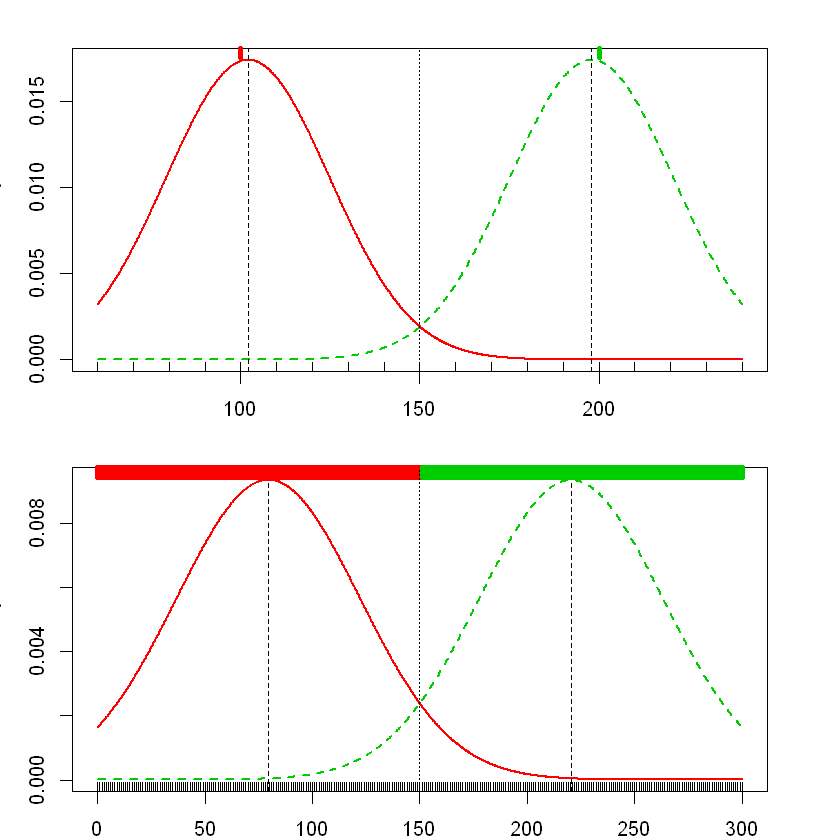

In [305]:
k <- c(rep(100, times = 10), rep(200, times = 10)) #Captain-labeled items 
clab <- c(rep(1, times = 10), rep(0, times = 10)) #Captain gives first 10 items in k label 1 and second 10 items label 0.

s1 <- c(rep(1, times = 51), rep(0, times = 250))  #Source 1 labels
s2 <- c(rep(1, times = 166), rep(0, times = 135))  #Source 2 labels      

mods <- plt.wgmm.seq(x=c(0:300), s1=s1, s2=s2, k=k, update = F) #Fit and plot models

Results are the same so we will use batch-fit model in rest of simulations.

### Experiment 2

In study 2 the initial learning (model 1) is the same a Experiment 1, so we will re-use here to generate weightings for the two-source learning phase. Specifically, we will use the initial model 1 as a model of the oracle and for each new item labeled by two sources, we will provide a weight of 1 to the provided label when the two sources agree, and a weight determined by the model 1 posterior probability curve when the two sources disagree:


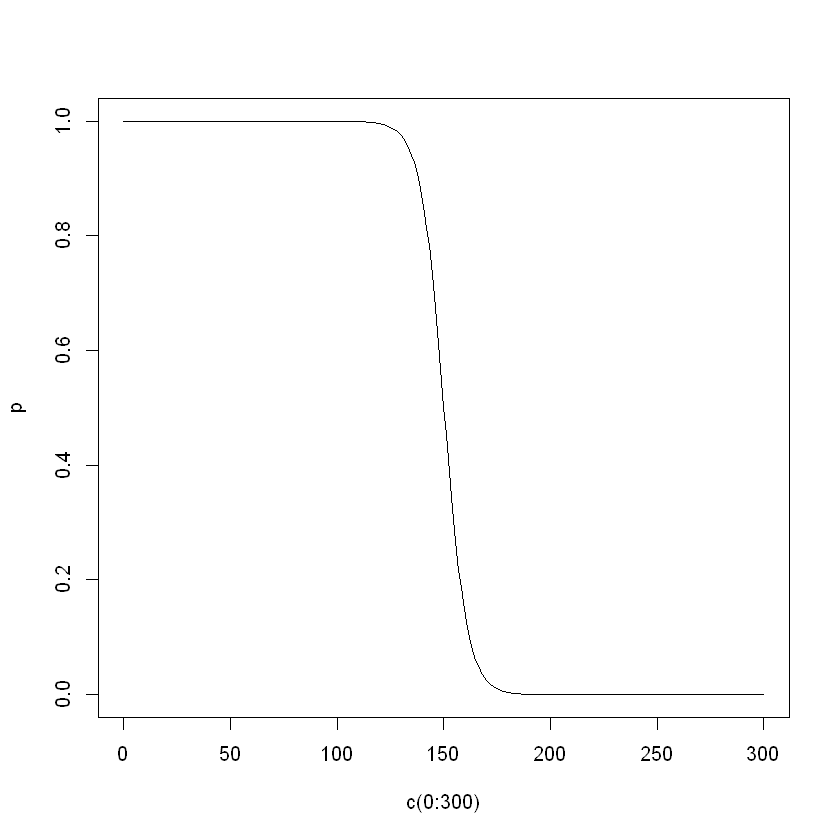

In [346]:
p <- predict(mod1, c(0:300))$tij.X[,1]
plot(c(0:300), p, type = "l")

In the experiment, each subject gets a different source-2 boundary, which varies across subjects in distance from the midpoint. So we will fit a separate model for each subject, systematically varying the distance of the second source. For each simulated subject, we use the initial and final models to estimate the boundary shift, and from this we compute the estimated weight $\theta$ given to the variable source as described in the paper. We then plot the estimate of $\theta$ against the distance of the varying source.

In [347]:
nsjs <- dim(e2s2)[1] #Number of simulated subjects

xnew <- c(0:3000)/10 #Grid points to find boundary

b2 <- rep(NA, times = nsjs) #Initialize vector for boundary-2

#Weight predicted by model of oracle
owt <- predict(mod1, c(0:300))$tij.X[,1]

for(i1 in c(1:nsjs)){
    #For each subject
    #probability that item gets label 1:
    agree <- e2s1==e2s2[i1,] #logical vector indicating where 2 source agree
    plab1 <- (e2s1 + e2s2[i1,])/2 #initialize with mean of source labels
    plab1[!agree] <- owt[!agree] #Where they disagree, replace with predicted prob given by mod1
    plab1 <- c(clab, plab1) #Append certain labels to beginning
    
    plab2 <- 1 - plab1  #Probability of other label is 1-plab1
    b <- cbind(plab1, plab2) #Bind into matrix
    
    #Fit model 2
    mod2 <- soft(knowns = k, X = uk, P = b)

    p <- predict(mod2, xnew)
    pdiff <- abs(p$tij.X[,1] - p$tij.X[,2])
    b2[i1] <- xnew[pdiff==min(pdiff)]
    }


bshift <- b2 - b1
round(bshift, 2)

[1] -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1  0.2  2.4

In [348]:
t.test(bshift)


	One Sample t-test

data:  bshift
t = 0.52071, df = 14, p-value = 0.6107
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.2703072  0.4436405
sample estimates:
 mean of x 
0.08666667 


On average boundary does not shift.

In [349]:
pwt <- rep(0, times = nsjs)
s <- b2 - b1   #Amount of shift
f <- rowSums(e2s2) - b1[1]  #Distance of variable source to initial boundary
c <- sum(e2s1) - b1[1]      #Distance of fixed source to initial boundary

for(i1 in c(1:15)) pwt[i1] <- get.pwt(s[i1], f[i1], c)

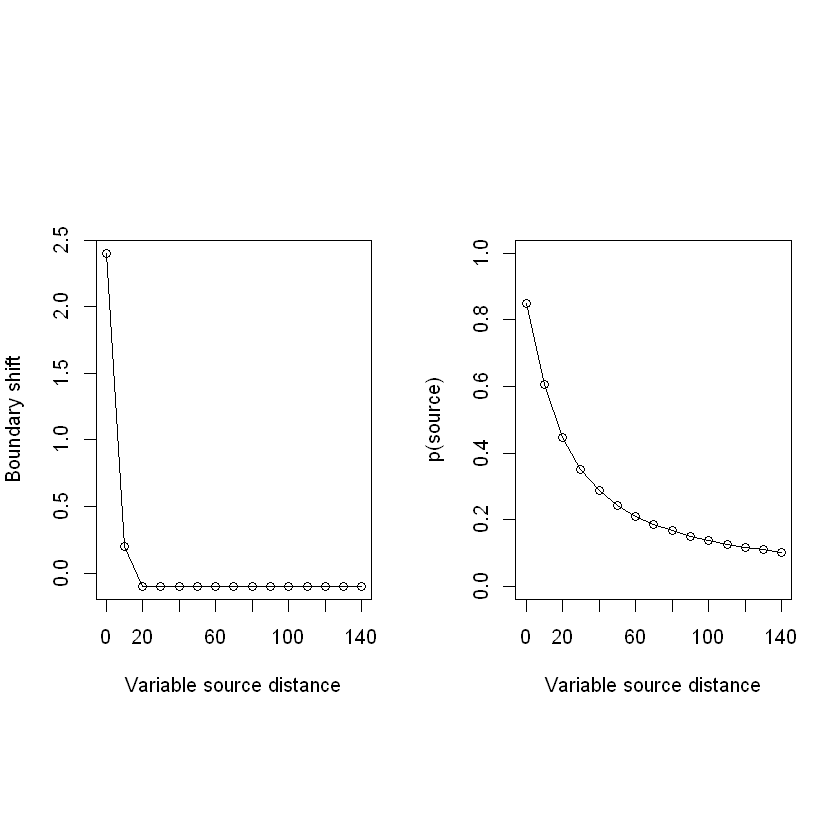

In [350]:
par(mfrow = c(1,2), mar = c(10,4,10,2))
plot(150 - rowSums(e2s2), b2- b1, type = "o", ylab = "Boundary shift", xlab = "Variable source distance")
plot(150 - rowSums(e2s2), pwt, type = "o", ylab = "p(source)", xlab = "Variable source distance",
    ylim = c(0,1))

In [351]:
postscript("e2_gmm_owt.ps", width=8, height=8)
par(mar = c(4,3,2,2))
plot(150 - rowSums(e2s2), pwt, type = "o", ylab = "p(source)", xlab = "Variable source distance",
    ylim = c(0,1), pch=16)
dev.off()

png 
  2

Curve begins to look similar to experiment but still not as steep, and boundary does not shift at all.

### Experiment 3

In experiment 3, the Captain provided labels at 70, 130, promoting an initial boundary near 100. Source 1 then used a boundary at 100, and source 2 a boundary at 200. We can simualte this study using the same code as experiment 1, but changing the fully-supervised (Captain's) labels, and using the experiment 3 labels for S1 and S2.

In [352]:
rm(mod1, mod2)

In [355]:
k <- e3citems #Replace items labelled by captain
b <- cbind(clab, 1-clab) #Certain labels for initial model
mod1 <- soft(knowns=k, X=uk[1:38], P=b) #Fit initial model

#Probability of label 1:
agree <- e3s1==e3s2 #Logical indicating where they agree
owt <- predict(mod1, x)$tij.X[,1] #Oracle-based probabilities
plab1 <-(e3s1 + e3s2)/2 #Initialize with mean of source labels
plab1[!agree] <- owt[!agree] #Where sources disagree, replace with oracle-based probabilities
plab1 <- c(clab, plab1) #append certain labels

plab2 <- 1 - plab1                #Probability of label 2

b <- cbind(plab1, plab2)          #Label probability matrix
k <- c(k, x)
mod2 <- soft(knowns = k, X = uk, P = b) #Fit model 2 

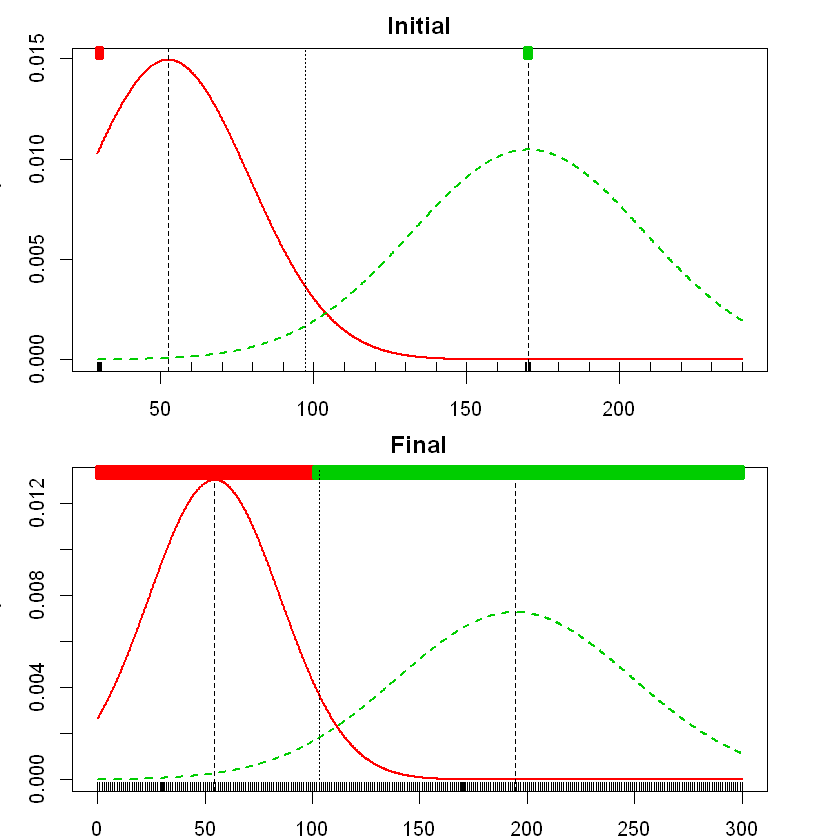

In [356]:
par(mfrow = c(2,1), mar = c(2,3,2,3)) #Plot a 2-row panel figure with margins set according to mar

#Mod1 boundary
bp <- predict(mod1, xnew)$tij.X
diff <- abs(bp[,1] - bp[,2])
b1 <- xnew[diff==min(diff)]

#Mod2 boundary
bp <- predict(mod2, xnew)$tij.X
diff <- abs(bp[,1] - bp[,2])
b2 <- xnew[diff==min(diff)]

par(mfrow = c(2,1))
plot(mod1); title("Initial"); abline(v=b1, lty = 3)
plot(mod2); title("Final"); abline(v=b2, lty = 3)


In [357]:
pdf("e3_gmm_owt.pdf", w=8, h=8)
par(mfrow = c(2,1), mar = c(2,3,2,3)) #Plot a 2-row panel figure with margins set according to mar
plot(mod1); abline(v = b1, lty = 3)     #Plot model 1 in the first panel and add a vertical dotted line at X = 150
plot(mod2); abline(v = b2, lty = 3)     #Plot model 2 in the second panel and add a vertical dotted line at X = 150
dev.off()

png 
  2

In [358]:
round(c(bm1, bm2, bm2-bm1),2)

[1]  97.4 103.4   6.0

Small shift toward midline

In [359]:
get.pwt(bm2-bm1, bm1, abs(100-bm1))

[1] 0.03586498

Much less weight given to far source

### Experiment 4

In this experiment the Captain provides the same labels as Experiment 3, and the two sources again provide labels based on boundaries equidistant from the range midpoint at 150. Different conditions vary *how far* from the midpoint the two source boundaries are (high agreement, moderate agreement, moderate disagreement, high disagreement). This block will therefore fit four different "after" models and compute the boundary shift for each.

In [360]:
x=c(0:300)
bshift <- rep(NA, times = 4) #Initialize vector to hold boundary shift results
xnew <- c(0:3000)/10 #Grid to find boundary

#High agreement condition
agree <- e4has1==e4has2 #Logical indicating where they agree
owt <- predict(mod1, x)$tij.X[,1] #Oracle-based probabilities
plab1 <-(e4has1 + e4has2)/2 #Initialize with mean of source labels
plab1[!agree] <- owt[!agree] #Where sources disagree, replace with oracle-based probabilities
plab1 <- c(clab, plab1) #append certain labels
plab2 <- 1 - plab1                #Probability of label 2
b <- cbind(plab1, plab2)          #Label probability matrix
modha <- soft(knowns = k, X = uk, P = b) #Fit high agreement model
p <- predict(modha, xnew)
pdiff <- abs(p$tij.X[,1] - p$tij.X[,2])
b2 <- xnew[pdiff==min(pdiff)]
bshift[1] <- b2 - 100

#Moderate agreement condition
agree <- e4mas1==e4mas2 #Logical indicating where they agree
owt <- predict(mod1, x)$tij.X[,1] #Oracle-based probabilities
plab1 <-(e3s1 + e3s2)/2 #Initialize with mean of source labels
plab1[!agree] <- owt[!agree] #Where sources disagree, replace with oracle-based probabilities
plab1 <- c(clab, plab1) #append certain labels
plab2 <- 1 - plab1                #Probability of label 2
b <- cbind(plab1, plab2)          #Label probability matrix
modma <- soft(knowns = k, X = uk, P = b) #Fit moderate agreement model
p <- predict(modma, xnew)
pdiff <- abs(p$tij.X[,1] - p$tij.X[,2])
b2 <- xnew[pdiff==min(pdiff)]
bshift[2] <- b2 - 100

#Moderate disagreement condition
agree <- e4mds1==e4mds2 #Logical indicating where they agree
owt <- predict(mod1, x)$tij.X[,1] #Oracle-based probabilities
plab1 <-(e3s1 + e3s2)/2 #Initialize with mean of source labels
plab1[!agree] <- owt[!agree] #Where sources disagree, replace with oracle-based probabilities
plab1 <- c(clab, plab1) #append certain labels
plab2 <- 1 - plab1                #Probability of label 2
b <- cbind(plab1, plab2)          #Label probability matrix
modmd <- soft(knowns = k, X = uk, P = b) #Fit moderate disagreement model
p <- predict(modmd, xnew)
pdiff <- abs(p$tij.X[,1] - p$tij.X[,2])
b2 <- xnew[pdiff==min(pdiff)]
bshift[3] <- b2 - 100

#High disagreement condition
agree <- e4hds1==e4hds2 #Logical indicating where they agree
owt <- predict(mod1, x)$tij.X[,1] #Oracle-based probabilities
plab1 <-(e3s1 + e3s2)/2 #Initialize with mean of source labels
plab1[!agree] <- owt[!agree] #Where sources disagree, replace with oracle-based probabilities
plab1 <- c(clab, plab1) #append certain labels
plab2 <- 1 - plab1                #Probability of label 2
b <- cbind(plab1, plab2)          #Label probability matrix
modhd <- soft(knowns = k, X = uk, P = b) #Fit high disagreement model
p <- predict(modhd, xnew)
pdiff <- abs(p$tij.X[,1] - p$tij.X[,2])
b2 <- xnew[pdiff==min(pdiff)]
bshift[4] <- b2 - 100



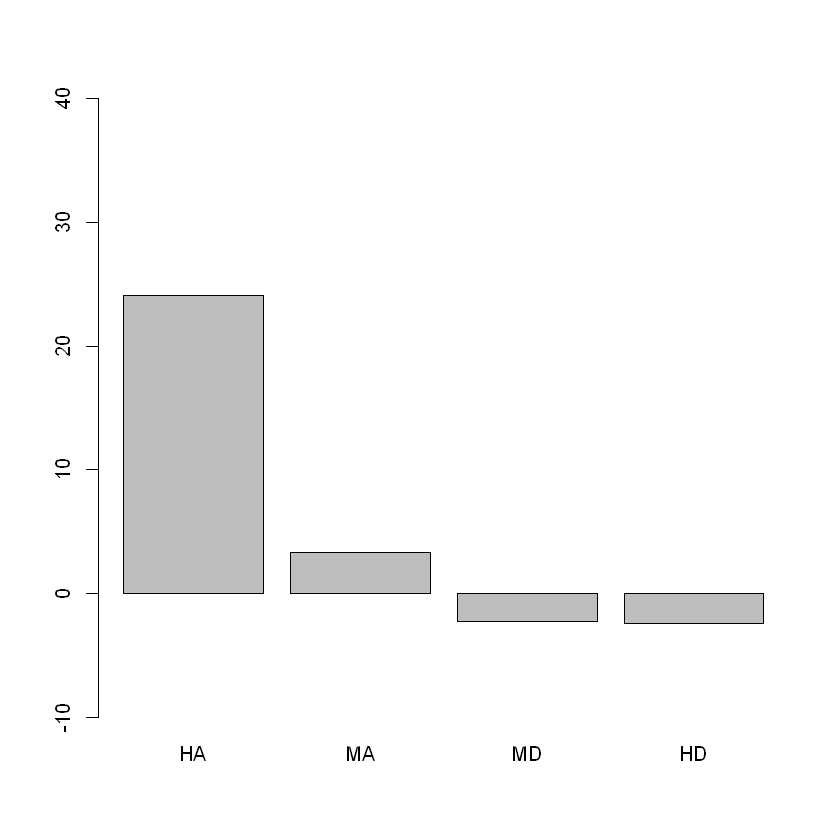

In [362]:
barplot(bshift, names=c("HA","MA","MD", "HD"), ylim = c(-10,40))

All models shift toward the midpoint, with stronger shift for higher agreement between sources.

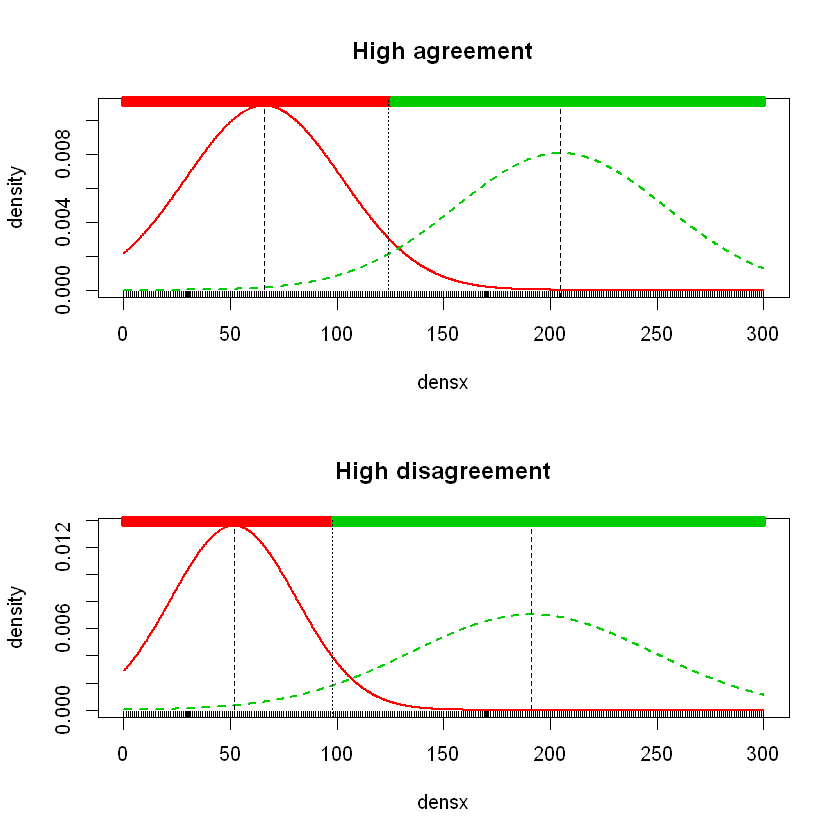

In [363]:
#HA boundary
bp <- predict(modha, xnew)$tij.X
diff <- abs(bp[,1] - bp[,2])
bha <- xnew[diff==min(diff)]

#HD boundary
bp <- predict(modhd, xnew)$tij.X
diff <- abs(bp[,1] - bp[,2])
bhd <- xnew[diff==min(diff)]

par(mfrow = c(2,1))
plot(modha); title("High agreement"); abline(v=bha, lty = 3)
plot(modhd); title("High disagreement"); abline(v=bhd, lty = 3)

# Learner-weighted models

In these simulations we use the learner's current model to determine soft weights for items labeled from the two sources. When both sources agree, the model is given probabilities of 1 for the corresponding label. When they disagree, however, the weight given to Label A is exactly the probability that the item has label A according to the learner's current model, and same for B. **Note** that, since weights are given according to the learner's model, and this model changes over time, the model must be fit online rather than getting updated once as a batch. Thus the order in which the items are encountered matters.

The function plot_wgmm_seq.R scrambles the order of items, then fits a sequence of gmms online with each new item, and computes boundary estimates at each iteration.

## Experiment 1

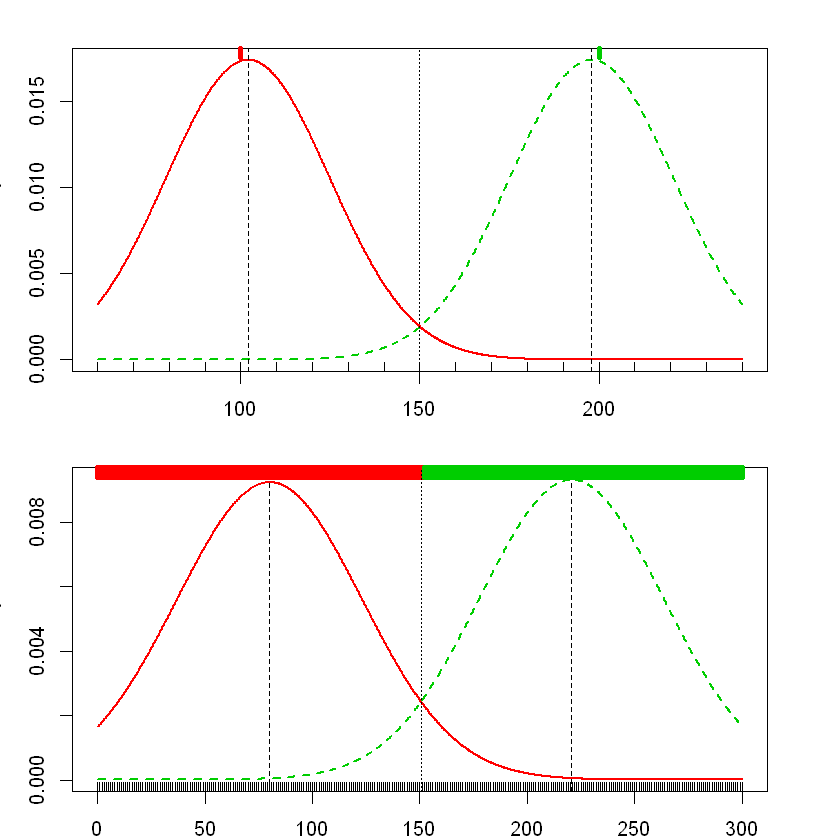

In [364]:
x <- c(0:300)
s1 <- c(rep(1, times = 51), rep(0, times = 250))  #Source 1 labels
s2 <- c(rep(1, times = 166), rep(0, times = 135))  #Source 2 labels      

bseq <- plt.wgmm.seq(x, s1, s2)

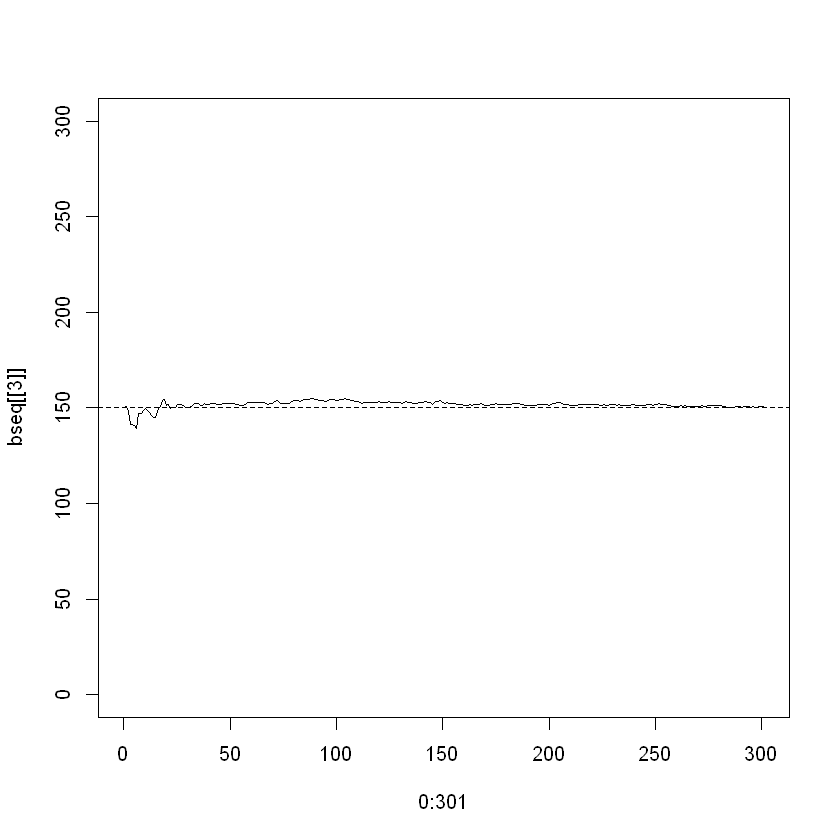

In [365]:
plot(0:301, bseq[[3]], ylim = c(0,300), type = "l"); abline(h=150, lty=2)

In [366]:
bseq <- bseq[[3]]
bseq[1] - bseq[length(bseq)]

[1] -0.7

Essentially no change in boundary location.

## Experiment 2

In the experiment, each subject gets a different source-2 boundary, which varies across subjects in distance from the midpoint. So we will fit a separate model for each subject, systematically varying the distance of the second source. For each simulated subject, we use the initial and final models to estimate the boundary shift, and from this we compute the estimated weight $\theta$ given to the variable source as described in the paper. We then plot the estimate of $\theta$ against the distance of the varying source.

**Note** this takes awhile as we are doing online learning---that is, fitting 301 models per subject.

In [371]:
nsjs <- dim(e2s2)[1] #Number of simulated subjects

xnew <- c(0:3000)/10 #Grid points to find boundary

b1 <- rep(NA, times = nsjs) #Initialize vector for boundary-1
b2 <- rep(NA, times = nsjs) #Initialize vector for boundary-2

for(i1 in c(1:nsjs)){
    #For each subject
    #probability that item gets label 1:
    sjbnd <- plt.wgmm.seq(c(0:300), e2s1, e2s2[i1,], pl=F)[[3]]
    b1[i1] <- sjbnd[1] #Initial boundary for this subject
    b2[i1] <- sjbnd[length(sjbnd)] #Final boundary for this subject
}


bshift <- b2 - b1
bshift

[1]  1.5  0.6 -1.1  0.7  2.5 -0.6 -1.3  1.5 -2.2 -3.5 -2.7  7.2  4.9  0.8  5.0

In [372]:
t.test(bshift)


	One Sample t-test

data:  bshift
t = 1.1316, df = 14, p-value = 0.2768
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.7939312  2.5672645
sample estimates:
mean of x 
0.8866667 


Boundary does not shift

In [373]:
pwt <- rep(0, times = nsjs)
s <- b2 - b1   #Amount of shift
f <- rowSums(e2s2) - b1[1]  #Distance of variable source to initial boundary
c <- sum(e2s1) - b1[1]      #Distance of fixed source to initial boundary

for(i1 in c(1:15)) pwt[i1] <- get.pwt(s[i1], f[i1], c)

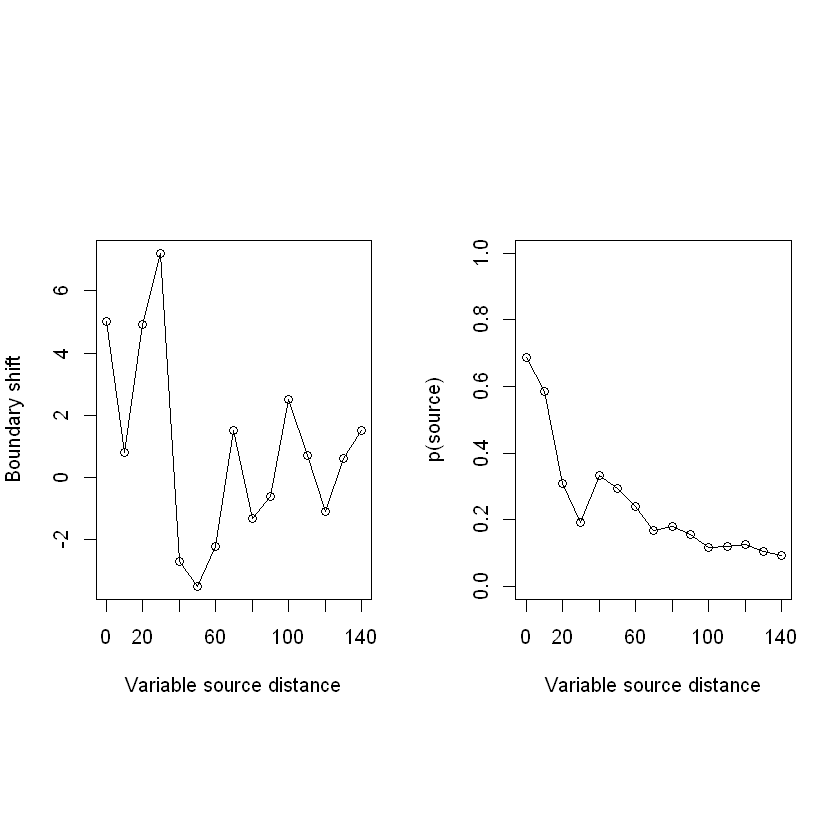

In [374]:
par(mfrow = c(1,2), mar = c(10,4,10,2))
plot(150 - rowSums(e2s2), b2- b1, type = "o", ylab = "Boundary shift", xlab = "Variable source distance")
plot(150 - rowSums(e2s2), pwt, type = "o", ylab = "p(source)", xlab = "Variable source distance",
    ylim = c(0,1))

In [375]:
postscript("e2_gmm_lwt.ps", width=8, height=8)
par(mar = c(4,3,2,2))
plot(150 - rowSums(e2s2), pwt, type = "o", ylab = "p(source)", xlab = "Variable source distance",
    ylim = c(0,1), pch=16)
dev.off()

png 
  2

Curve doesn't resemble data

### Experiment 3

In experiment 3, the Captain provided labels at 70, 130, promoting an initial boundary near 100. Source 1 then used a boundary at 100, and source 2 a boundary at 200. We can simualte this study using the same code as experiment 1, but changing the fully-supervised (Captain's) labels, and using the experiment 3 labels for S1 and S2.

Warning message in if (is.na(k)) k <- c(rep(100, times = 10), rep(200, times = 10)):
"the condition has length > 1 and only the first element will be used"

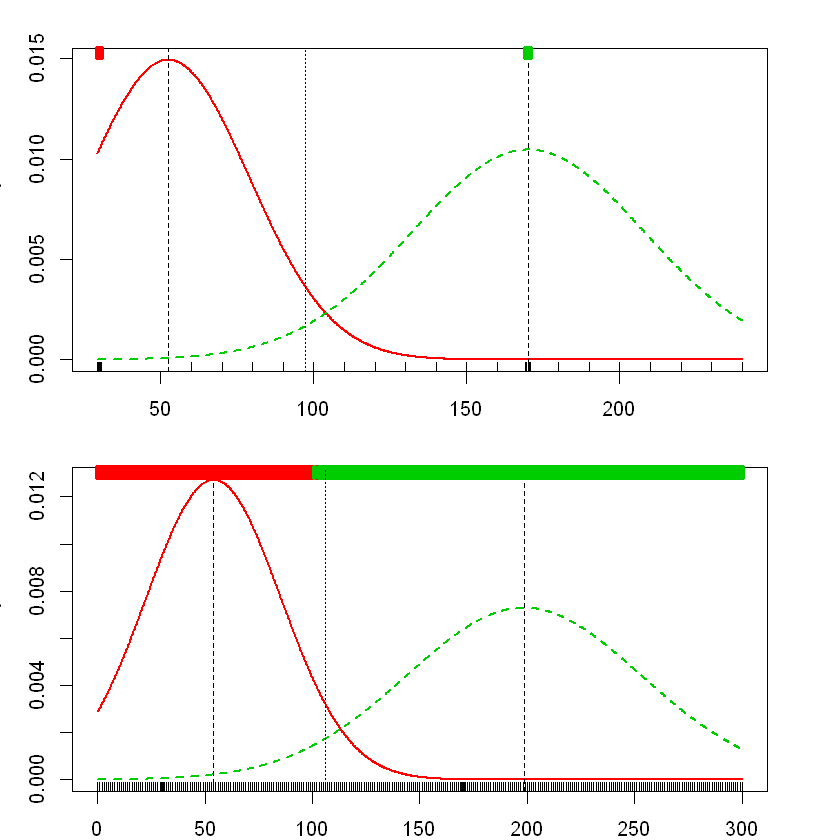

In [376]:
bseq <- plt.wgmm.seq(x=c(0:300), k = e3citems, s1 = e3s1, s2 = e3s2)

In [379]:
pdf("e3_gmm_lwt.pdf", w=8,h=8)
par(mar = c(2,3,2,3)) #Plot a 2-row panel figure with margins set according to mar
bseq <- plt.wgmm.seq(x=c(0:300), k = e3citems, s1 = e3s1, s2 = e3s2)
dev.off()

Warning message in if (is.na(k)) k <- c(rep(100, times = 10), rep(200, times = 10)):
"the condition has length > 1 and only the first element will be used"

png 
  2

Note the boundary is offset from the crossing point between distributions b/c, when initial boundary is offset from midpoint, there is a higher prior on category 2 (green)--so it remains a bit more probable even when probability density function for category 1 is a bit higher.

In [380]:
bseq <- bseq[[3]]
s <- bseq[length(bseq)] - bseq[1]
s

[1] 6.8

Small shift toward midline

In [381]:
get.pwt(s, bseq[1], abs(100-bseq[1]))

[1] 0.04334038

Much less weight given to far source

### Experiment 4

In this experiment the Captain provides the same labels as Experiment 3, and the two sources again provide labels based on boundaries equidistant from the range midpoint at 150. Different conditions vary *how far* from the midpoint the two source boundaries are (high agreement, moderate agreement, moderate disagreement, high disagreement). This block will therefore fit four different "after" models and compute the boundary shift for each.

In [382]:
bshift <- rep(NA, times = 4) #Initialize vector to hold boundary shift results

#High agreement condition
mods <- plt.wgmm.seq(x=c(0:300), s1=e4has1, s2=e4has2, k=e3citems, pl=F)
bseq <- mods[[3]]
bshift[1] <- bseq[length(bseq)] - bseq[1]
modha <- mods[[2]]

#Moderate agreement condition
mods <- plt.wgmm.seq(x=c(0:300), s1=e4mas1, s2=e4mas2, k=e3citems,  pl=F)
bseq <- mods[[3]]
bshift[2] <- bseq[length(bseq)] - bseq[1]
modma <- mods[[2]]

#Moderate disagreement condition
mods <- plt.wgmm.seq(x=c(0:300), s1=e4mds1, s2=e4mds2, k=e3citems,  pl=F)
bseq <- mods[[3]]
bshift[3] <- bseq[length(bseq)] - bseq[1]
modmd <- mods[[2]]

#High disagreement condition
mods <- plt.wgmm.seq(x=c(0:300), s1=e4hds1, s2=e4hds2, k=e3citems,  pl=F)
bseq <- mods[[3]]
bshift[4] <- bseq[length(bseq)] - bseq[1]
modhd <- mods[[2]]


Warning message in if (is.na(k)) k <- c(rep(100, times = 10), rep(200, times = 10)):
"the condition has length > 1 and only the first element will be used"Warning message in if (is.na(k)) k <- c(rep(100, times = 10), rep(200, times = 10)):
"the condition has length > 1 and only the first element will be used"Warning message in if (is.na(k)) k <- c(rep(100, times = 10), rep(200, times = 10)):
"the condition has length > 1 and only the first element will be used"Warning message in if (is.na(k)) k <- c(rep(100, times = 10), rep(200, times = 10)):
"the condition has length > 1 and only the first element will be used"

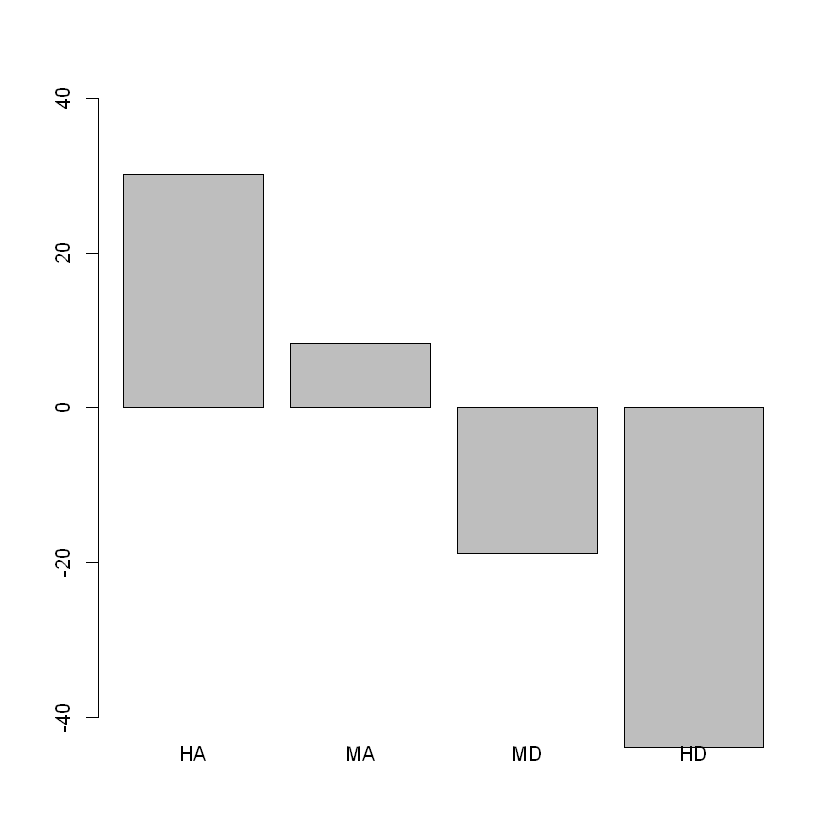

In [388]:
barplot(bshift, names=c("HA","MA","MD", "HD"), ylim = c(-40,40))

Closer sources produce shift toward midline; farther sources produce shift toward poles

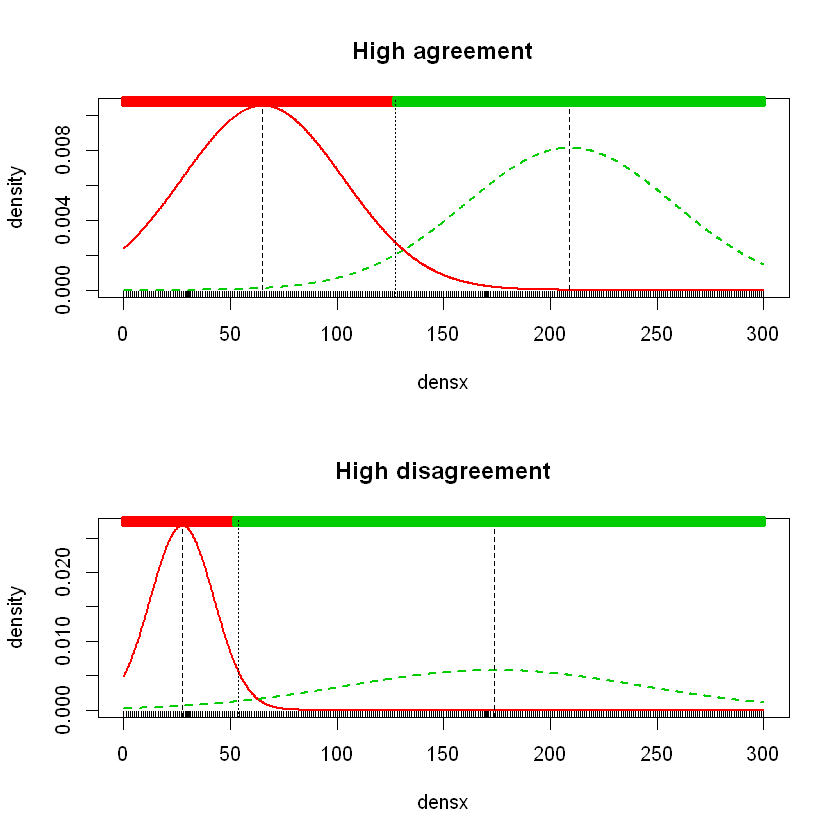

In [385]:
#HA boundary
bp <- predict(modha, xnew)$tij.X
diff <- abs(bp[,1] - bp[,2])
bha <- xnew[diff==min(diff)]

#HD boundary
bp <- predict(modhd, xnew)$tij.X
diff <- abs(bp[,1] - bp[,2])
bhd <- xnew[diff==min(diff)]

par(mfrow = c(2,1))
plot(modha); title("High agreement"); abline(v=bha, lty = 3)
plot(modhd); title("High disagreement"); abline(v=bhd, lty = 3)

## Scratch

In [ ]:
k <- c(rep(100, times = 10), rep(200, times = 10), 0:300) 
clab <- c(rep(1, times = 10), rep(0, times = 10)) #Captain gives first 10 items in k label 1 and second 10 items label 0.

s1 <- c(rep(1, times = 51), rep(0, times = 250))  #Source 1 labels
s2 <- c(rep(1, times = 166), rep(0, times = 135))  #Source 2 labels        

lmod <- soft(knowns = k[1:20], X = uk[1:38], P = b[1:20,]) #First 20 knowns and first 38 unknowns, on the grid
s1mod <-supervised (knowns=k, class=2 - c(clabs, s1))
s2mod <-supervised (knowns=k, class=2 - c(clabs, s2))


In [ ]:
plot(lmod)